# Testing code for my 2.5D forward simulation and inversion using simpeg

In this file I define all the functions explicitly, which in the `.py` files I import from `functions.py` instead.

In [1]:
#imports

# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder, download
from simpeg.utils.solver_utils import get_default_solver
from simpeg.utils.io_utils import read_dcip2d_ubc
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    generate_survey_from_abmn_locations,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# Suppress the DefaultSolverWarning
import warnings
import simpeg.utils.solver_utils  # Ensure the module is imported
warnings.filterwarnings('ignore', category=simpeg.utils.solver_utils.DefaultSolverWarning)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz


# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile

mpl.rcParams.update({"font.size": 14})  # default font size
cmap = mpl.cm.RdYlBu_r  # default colormap

### Read in the res2dinv file to define the survey layout and resistivity values, as well as getting electrode locations (topo)



There is the option to set `std_method` to either `"measured"` (uses data from the file) or `"constant"` which sets all points with a 5% error.

In [2]:
def generate_dcdata_from_res2dinv(file_path, std_method="measured"):
    """
    Extracts electrode positions, resistivity and error data from a RES2DINV .dat file and generates a survey using SimPEG's generate_survey_from_abmn_locations function.

    This function reads a resistivity survey file in RES2DINV format and extracts:
    - Electrode coordinates (X, Z) for each measurement
    - Apparent resistivity values (Ωm)
    - Measurement error percentages

    Chargeability data (if present) is ignored.

    Parameters:
    ----------
    file_path : str
        Path to the .dat file containing the resistivity survey data.
    std_method : str, optional
        "measured" to use the given uncertainty for each data point
        "constant" to use a constant percentage error for all points of 5% (default is "measured").

    Returns
    -------
    dc_data : SimPEG `data.Data` object containing the survey and resistivity values.

    Example:
    -------
    >>> data = generate_dcdata_from_res2dinv("survey.dat")
    >>> print(data[0])
    {'electrodes': [(10.0, 0.0), (40.0, 0.0), (20.0, 0.0), (30.0, 0.0)],
     'resistivity': 82.437,
     'error': 12.183}
    """
    with open(file_path, "r") as file:
        lines = file.readlines()

    num_data_points = int(lines[6].strip())  # Number of data points

    # Read the data section
    A = np.zeros((num_data_points, 2))
    B = np.zeros((num_data_points, 2))
    M = np.zeros((num_data_points, 2))
    N = np.zeros((num_data_points, 2))
    dobs = np.zeros(num_data_points)
    error = np.zeros(num_data_points)

    data_start_line = 12
    for i, line in enumerate(
        lines[data_start_line : data_start_line + num_data_points]
    ):
        values = line.strip().split()
        if len(values) >= 11:
            A[i] = [float(values[1]), float(values[2])]
            B[i] = [float(values[3]), float(values[4])]
            M[i] = [float(values[5]), float(values[6])]
            N[i] = [float(values[7]), float(values[8])]
            dobs[i] = float(values[9])  # Apparent resistivity
            error[i] = float(values[10])  # Error percentage

    # Extract unique topography points (electrode locations) and center around 0
    electrodes = np.vstack((A, B, M, N))
    midpoint_electrodes = (np.max(electrodes[:, 0]) - np.min(electrodes[:, 0])) / 2
    electrodes[:, 0] = electrodes[:, 0] - midpoint_electrodes
    topo = np.unique(electrodes, axis=0)  # Remove duplicates
    A[:, 0] -= midpoint_electrodes
    B[:, 0] -= midpoint_electrodes
    M[:, 0] -= midpoint_electrodes
    N[:, 0] -= midpoint_electrodes

    # Generate the survey
    survey = generate_survey_from_abmn_locations(
        locations_a=A,
        locations_b=B,
        locations_m=M,
        locations_n=N,
        data_type="volt",
    )

    # Determine the standard deviation for the error
    if std_method == "measured":
        # Use relative_error: measured error percentages
        relative_error = np.abs(error) / 100  # Convert error to decimal percentage
        dc_data = data.Data(
            survey, dobs=dobs, noise_floor=1e-7, relative_error=relative_error
        )
    elif std_method == "constant":
        # Use relative_error with constant percentage (e.g., 5%)
        std = 1e-7 + 0.05 * np.abs(dobs)  # 5% constant error
        dc_data = data.Data(survey, dobs=dobs, standard_deviation=std)
    else:
        # Handle the case when an invalid `std_method` is passed
        warnings.warn("Invalid std_method. Defaulting to 'measured'.")
        relative_error = np.abs(error) / 100  # Default to measured error
        dc_data = data.Data(survey, dobs=dobs, relative_error=relative_error)

    # Plot electrode positions
    plot_electrode_positions(topo, electrodes)

    return dc_data, topo


def plot_electrode_positions(topo, electrodes):
    """
    Plots all electrode positions as black dots along with the survey topography as a line.

    Parameters
    ----------
    topo : np.ndarray, shape (N, 2)
        Array of unique survey topography points [(x1, z1), (x2, z2), ...].
    electrodes : np.ndarray, shape (M, 2)
        Array of all electrode positions [(x1, z1), (x2, z2), ...].

    Returns
    -------
    None
    """
    plt.figure(figsize=(8, 5))

    # Plot topography line
    if topo is not None:
        sorted_topo = topo[np.argsort(topo[:, 0])]  # Sort by x-coordinates
        plt.plot(
            sorted_topo[:, 0],
            sorted_topo[:, 1],
            color="black",
            linestyle="-",
            linewidth=1.5,
            label="Topography",
        )

    # Plot electrodes as black dots
    plt.scatter(
        electrodes[:, 0],
        electrodes[:, 1],
        color="red",
        marker="o",
        s=20,
        label="Electrodes",
    )

    # Labels and formatting
    plt.xlabel("X Position (m)")
    plt.ylabel("Z Position (m)")
    plt.title("Electrode Positions with Topography")
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()  # Invert Z-axis to show depth correctly

    # plt.show()


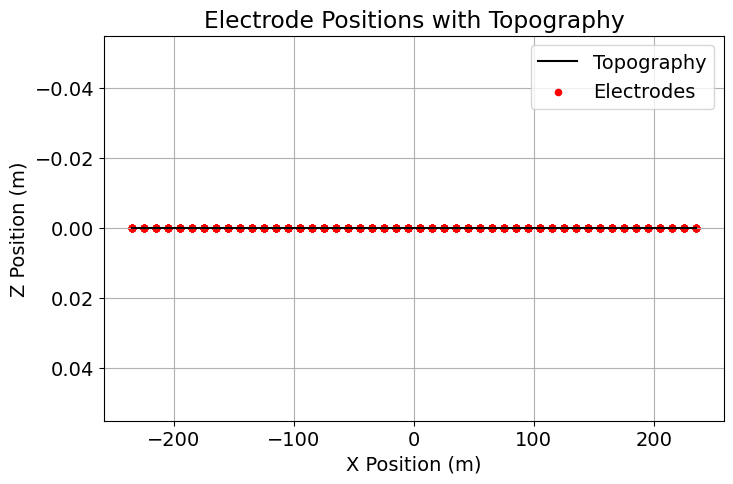

In [3]:
# extract data from file, plot survey layout
file_path = "data/Project4_Wenner_1.dat"
voltage_data, topo = generate_dcdata_from_res2dinv(file_path, std_method="measured")

### Define topography

The data file only includes the topography exactly over the survey area and only at the electrode points. Using the topography from the electrode points, interpolate the topography to `n_points` and plot it (most of the files have 0 topography).


In [4]:
def haversine(lat1, lon1, lat2, lon2):
    """Compute Haversine distance between two lat/lon points."""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return 2 * 6371000 * np.arcsin(np.sqrt(a))

def create_topo(file_path, electrode_x_min, electrode_x_max, n_points, flat=False):
    """
    Reads in topography data, redefines the x-range to match electrode positions,
    and interpolates the elevation over the new range.

    Parameters:
        file_path (str): Path to the input file.
        electrode_x_min (float): Minimum x position of electrodes.
        electrode_x_max (float): Maximum x position of electrodes.
        n_points (int): Number of points in the interpolated profile.
        flat (bool): If True, returns a flat terrain.

    Returns:
        np.ndarray: A 2-column NumPy array with [electrode_x, elevation].
    """
    # Load data from file (assuming tab or space delimiter, skipping header)
    data = np.loadtxt(file_path, skiprows=1, usecols=(1, 2, 3))

    # Extract latitude, longitude, and altitude
    lat, lon, alt = data[:, 0], data[:, 1], data[:, 2]

    # Compute cumulative distances along the track
    distances = np.zeros(len(lat))
    for i in range(1, len(lat)):
        distances[i] = distances[i - 1] + haversine(lat[i - 1], lon[i - 1], lat[i], lon[i])

    # Map the original distances to a new range (-235 to 235 or given range)
    x_original_min, x_original_max = distances[0], distances[-1]

    # Compute the new x positions based on electrode limits
    topo_x = np.linspace(electrode_x_min, electrode_x_max, n_points)

    if not flat:
        # Interpolate elevation profile using cubic interpolation
        interp_func = interp1d(
            np.linspace(electrode_x_min, electrode_x_max, len(distances)),  # Map old x to new x
            alt,
            kind="cubic",
            fill_value="extrapolate"
        )
        topo_z = interp_func(topo_x)
    else:
        topo_z = np.zeros_like(topo_x)

    # Combine into a 2D NumPy array
    topo_2d = np.column_stack((topo_x, topo_z))

    return topo_2d


In [6]:
elev_filepath = 'data/Project4_Wenner_1_elev_profile.txt'
n_points = 401
elec_min = np.min(topo[:,0])
elec_max = np.max(topo[:,0])
topo_2d = create_topo(elev_filepath, elec_min, elec_max, n_points)

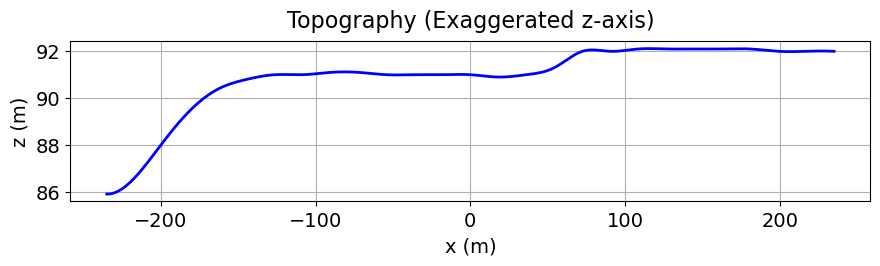

In [7]:
# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d[:,0], topo_2d[:,1], color="b", linewidth=2)
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=10)
plt.show(fig)

## Plot pseudosections
- the normalised voltages (resistivities) for each electrode spacing
- the errors associated with each measurement (will depend if `"measured"` or `"constant"` used when data is read in.
- Apparent resistivity

Text(0.5, 1.0, 'Apparent Resistivity')

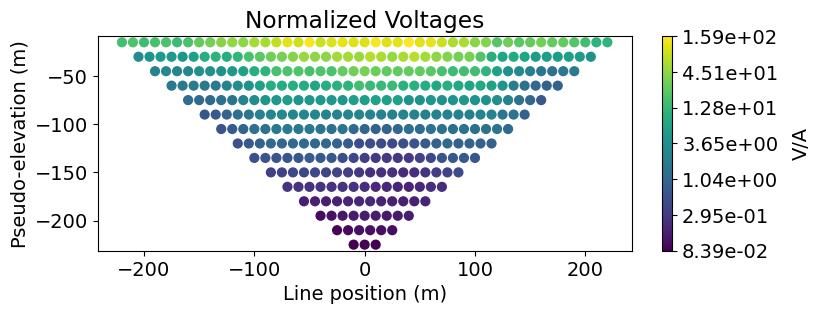

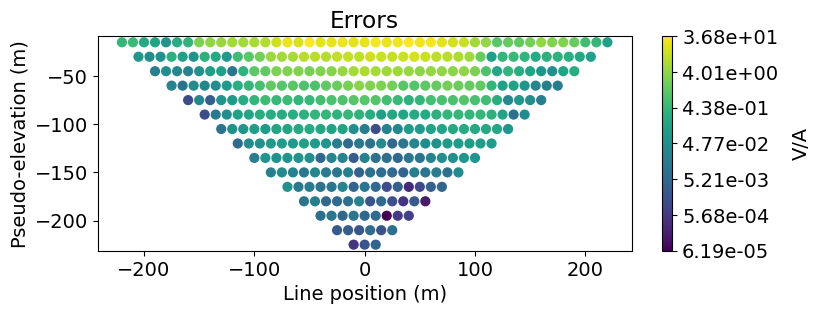

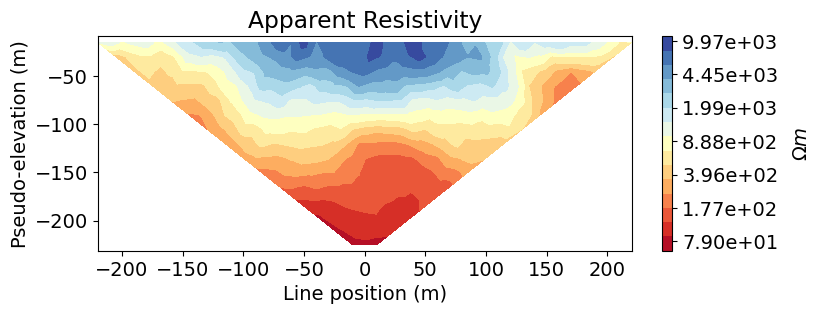

In [8]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")

# Plot errors pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    voltage_data.standard_deviation,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Errors")

# Get apparent resistivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(
    voltage_data.survey, voltage_data.dobs
)

# Plot apparent resistivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    apparent_resistivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu},
)
ax1.set_title("Apparent Resistivity")


## Design a Tree Mesh

Uses discretize package. Electrode potential falls off as $r^{-3}$ so smaller cells at top and larger away from them. Considerations are as follows:

* No currents in the air, no padding upwards needed, top of mesh is top of topography.
* At least 2-3 cells between current electrodes. More accurate with smaller cells.
* Padding thickness at least 2-3 times the largest electrode spacing.
* Increase ain cell size shouldn't happen too abruptly, at least 4 cells thick before increasing.
* Finer discretization when topography is significant.


In [ ]:
# Compute electrode spacing parameters
electrode_x = voltage_data.survey.unique_electrode_locations[:, 0]
max_spacing = np.max(electrode_x) - np.min(electrode_x)
min_spacing = np.min(np.diff(np.sort(electrode_x)))

cell_size = min_spacing / 10  # base cell width
dom_width_x = max_spacing * 8  # domain width x
dom_width_z = max_spacing * 8  # domain width z

# Compute number of base cells (rounded to power of 2)
nbcx = 2 ** int(np.round(np.log(dom_width_x / cell_size) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(dom_width_z / cell_size) / np.log(2.0)))

# Define the base mesh with top at z = 0 m.
hx = [(cell_size, nbcx)]
hz = [(cell_size, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, topo_2d[:, 1].max()]

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d,
    padding_cells_by_level=[0, 0, 6, 8],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = voltage_data.survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[10, 15, 8, 8], finalize=False
)

mesh.finalize()

In [ ]:
# print properties

print("# of cells: {}".format(mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])  # Cell center locations

In [ ]:
# plot mesh

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
mesh.plot_grid(ax=ax1, linewidth=1)
ax1.grid(False)
ax1.set_xlim(-600, 600)
ax1.set_ylim(np.max(topo_2d[:,1]) - 300, np.max(topo_2d[:,1])+50)
ax1.set_title("Mesh")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

plt.show()


## Define active cells

i.e. set the cells above the surface as 'inactive cells' as their physical properties are fixed

In [ ]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

## Define and plot the model

Made a model that contains multiple layers (active layer, permafrost, bedrock). 

In future can add ice lenses or wedges here and see how well they are recovered

In [ ]:
# define the model
air_cond = 1e-8
active_layer_cond = 1 / 50
perma_layer_cond = 1 / 600
bedrock_cond = 1 / 10000

In [ ]:
#use simpeg model builder functions to create the 3 layers
conductivity_model = model_builder.create_layers_model(
        mesh.cell_centers,
        layer_tops=np.array([0, -20]),
        layer_values=np.array([active_layer_cond, perma_layer_cond]),
    )

In [ ]:
# Conductivity map. Model parameters are conductivities for all active cells.
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_cond)

In [ ]:
# Generate a mapping to ignore inactice cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-50, 10)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

**Issues** - The layers are not well captured by the mesh because the mesh becomes larger than the layer depth. 

Should I make the mesh smaller?...

In [ ]:
# make sure the electrodes are mapped to being ON the surface, not below or especially not above
voltage_data.survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define Forward Simulation

Could also use Simulation2DCellCentered but Simulation2DNodel defines the electrical potential at nodes and is more well-suited for SURFACE resistivity data. Cell Centered good for borehole data.

Muse connect the simulation object to
* the survey
* the mesh
* the mapping from the model to the mesh
by setting each of these as a property of the simulation object.

In [ ]:
# Map model parameters to all cells
log_conductivity_map = maps.InjectActiveCells(mesh, active_cells, 1e-8) * maps.ExpMap(
    nP=np.sum(active_cells)
)

voltage_simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=voltage_data.survey, sigmaMap=log_conductivity_map, storeJ=True
)

## Get predicted data

In [ ]:
dpred_con = voltage_simulation.dpred(conductivity_model)

## Plot in pseudosection

In [ ]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    dobs=np.abs(dpred_con),
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_conductivities = 1 / apparent_resistivity_from_voltage(voltage_data.survey, dpred_con)

# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    dobs=apparent_conductivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="S/m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Conductivity")
plt.show()

# INVERSION

## Starting model, median of the apparent resistivities

Can also use my fake model as the starting model at some point.

In [ ]:
# Median apparent resistivity
median_resistivity = np.median(apparent_resistivities)

# Create starting model from log-conductivity
starting_conductivity_model = np.log(1 / median_resistivity) * np.ones(n_active)

# Zero reference conductivity model
reference_conductivity_model = starting_conductivity_model.copy()

In [ ]:
median_resistivity

## Data misfit (L2 norm)

In [ ]:
#put the dobs from the model into a simpeg data.Data object

std = 1e-7 + 0.05 * np.abs(dpred_con)  # 5% constant error
dc_data = data.Data(survey=voltage_data.survey, dobs=dpred_con, standard_deviation=std)

In [ ]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=voltage_simulation, data=dc_data)

## Regularization

In [ ]:
reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    alpha_s=cell_size**-2,
    alpha_x=1,
    alpha_y=1,
    reference_model=reference_conductivity_model,
    reference_model_in_smooth=False,
)

## Optimization

In [ ]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=40, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

## Inverse problem

In [ ]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

## Inversion directives

In [ ]:
sensitivity_weights = directives.UpdateSensitivityWeights(
    every_iteration=True, threshold_value=1e-2
)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=2.0)

directives_list_L2 = [
    # sensitivity_weights,
    # update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

## Design and run inversion

In [ ]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
# recovered_model_L2 = inv_L2.run(np.log(0.01) * np.ones(n_param))
recovered_log_conductivity_model = inv_L2.run(starting_conductivity_model)

## Plot misfit

In [ ]:
# Predicted data from recovered model
dpred = inv_prob_L2.dpred
dobs = voltage_data.dobs
std = voltage_data.standard_deviation

# Plot
fig = plt.figure(figsize=(9, 11))
data_array = [np.abs(dobs), np.abs(dpred), (dobs - dpred) / std]
plot_title = ["Observed Voltage", "Predicted Voltage", "Normalized Misfit"]
plot_units = ["V/A", "V/A", ""]
scale = ["log", "log", "linear"]
cmap_list = [mpl.cm.viridis, mpl.cm.viridis, mpl.cm.RdYlBu]

ax1 = 3 * [None]
cax1 = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.15, 0.72 - 0.33 * ii, 0.65, 0.21])
    cax1[ii] = fig.add_axes([0.81, 0.72 - 0.33 * ii, 0.03, 0.21])
    cplot[ii] = plot_pseudosection(
        voltage_data.survey,
        data_array[ii],
        "contourf",
        ax=ax1[ii],
        cax=cax1[ii],
        scale=scale[ii],
        cbar_label=plot_units[ii],
        mask_topography=True,
        contourf_opts={"levels": 25, "cmap": cmap_list[ii]},
    )
    ax1[ii].set_title(plot_title[ii])

plt.show()

## Plot recovered model

In [ ]:
# Convert log-conductivity values to conductivity values
recovered_conductivity_L2 = np.exp(recovered_log_conductivity_model)

# Define a mapping to plot models and ignore inactive cells
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

norm = LogNorm(vmin=5e-4, vmax=2e-1)

fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * recovered_conductivity_L2,
    normal="Y",
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-40, 00)
ax1.set_title("Recovered Conductivity Model (L2)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()